$$ q = \nabla f_k, \quad \alpha_i = 0 \quad \text{для i = 1, ..., m} $$
$$ \text{для i = k-1, k-2, ..., k-m \quad do:} $$
$$ \quad \alpha_i = \rho_i s_i^T q $$
$$ \quad q = q - \alpha_i y_i $$
$$ r = H_0 q $$
$$ \text{для i = k-m, ..., k-2, k-1 \quad do:} $$
$$ \quad \beta = \rho_i y_i^T r $$
$$ \quad r = r + s_i (\alpha_i - \beta) $$
$$ p_{k+1} = -r $$

где

$$ H_0 = \frac{s_{k-m}^T y_{k-m}}{y_{k-m}^T y_{k-m}} \quad \text{или} \quad H_0 = I $$

и

$$ \rho_i = \frac{1}{y_i^T s_i} $$

а $s_i$ и $y_i$ хранятся в лимитированной очереди (ограниченной длины m), которая обновляется на каждой итерации.


L-BFGS          ==>  -0.041983 in [ -0.822934,  -0.499453] in 11 steps.


<Figure size 800x800 with 0 Axes>

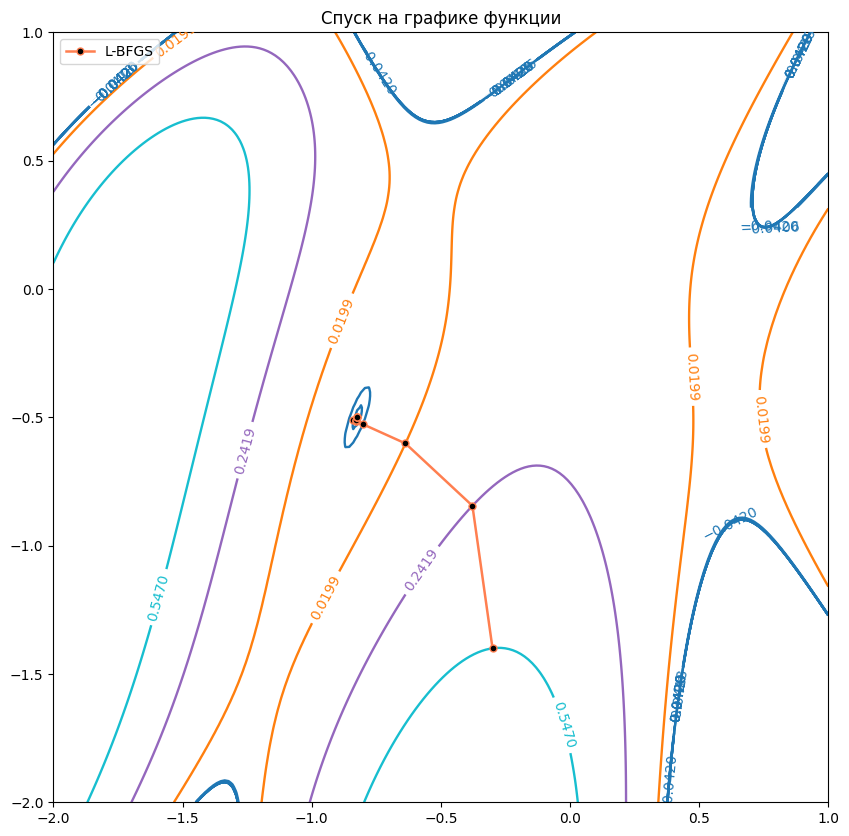

L-BFGS          ==>  -0.041983 in [ -0.822934,  -0.499453] in 11 steps.


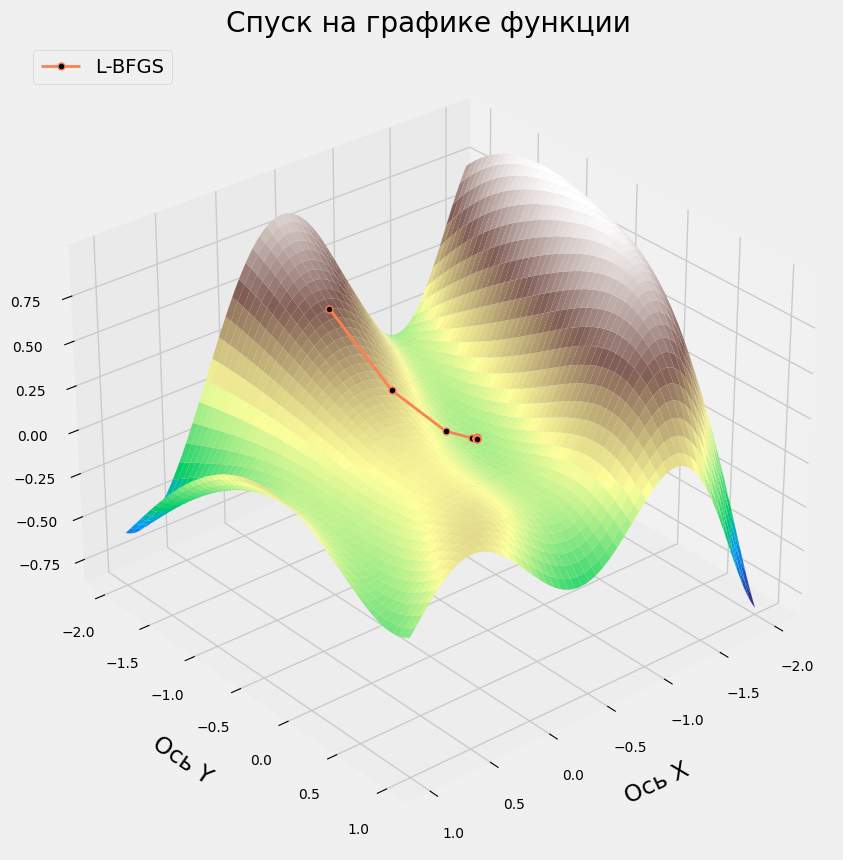

In [16]:
from matplotlib import pyplot as plt
import math
import numpy as np
from collections import deque
from scipy.optimize import line_search
from scipy.optimize import rosen, rosen_der
from dataset_generator import Generator

# % matplotlib inline
_ = plt.figure(figsize=(8, 8))


class file_info_3d:
    def __init__(self, X=None, Y=None, f=None, x0=None):
        self.X = X
        self.Y = Y
        self.Z = np.vectorize(lambda x, y: f(np.array([x, y])))(X, Y)
        self.f = f
        self.x0 = x0


def print_full_grad(file_info, list_result, list_label, title='Спуск на графике функции', elev=45, azim=50,
                    filename='', filename_extension='.png', dpi=1024, isshow=True):
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.plot_surface(file_info.X, file_info.Y, file_info.Z, linewidth=0, antialiased=True, shade=True, cmap='terrain')

    x = list_result[:, 0]
    y = list_result[:, 1]
    z = np.vectorize(lambda x, y: file_info.f(np.array([x, y])))(x, y)
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', color='coral', zs=z, label=list_label,
            linewidth=2)
    print(
        f'{list_label:15} ==> {file_info.f(list_result[-1]):10f} in [{list_result[-1][0]:10f}, {list_result[-1][1]:10f}] in {len(list_result)} steps.')

    ax.view_init(elev=elev, azim=azim)

    # Установка отступа между графиком и значениями осей
    ax.tick_params(pad=10)

    # Добавление легенды
    if len(list_label) > 0:
        ax.legend(loc='upper left')

    # Установка размера шрифта для подписей осей
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='z', labelsize=10)

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    ax.set_xlabel('Ось X', labelpad=20.0)
    ax.set_ylabel('Ось Y', labelpad=20.0)
    ax.set_zlabel('Ось f(x, y)', labelpad=20.0)

    if (filename != ''):
        plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()


def print_lines_grad(file_info_3d, result, label, nth=1, title='Спуск на графике функции', filename='',
                     filename_extension='.png', dpi=512):
    plt.style.use('default')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    list_result_nth = result[0::nth]

    if not np.array_equal(list_result_nth[-1], result[-1]):
        list_result_nth = np.vstack([list_result_nth, result[-1]])

    levels = np.unique(sorted([file_info_3d.f(p) for p in list_result_nth]))
    cs = ax.contour(file_info_3d.X, file_info_3d.Y, file_info_3d.Z, levels=levels, antialiased=True, linewidths=1.7,
                    cmap='tab10')
    cs.clabel()

    x = list_result_nth[:, 0]
    y = list_result_nth[:, 1]
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', color='coral', label=label, linewidth=1.8)
    print(
        f'{label:15} ==> '
        f'{file_info_3d.f(result[-1]):10f} in [{result[-1][0]:10f}, {result[-1][1]:10f}] in {len(result)} steps.')

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    # Добавление легенды
    if len(label) > 0:
        plt.legend(loc='upper left')

    if filename != '':
        plt.savefig(filename + '_lines' + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()


def f(x):
    return np.sin(0.5 * x[0] ** 2 - 0.25 * x[1] ** 2 + 3) * np.cos(2 * x[0] + 1 - np.exp(x[1]))


def grad(x, h=1e-5, delta=1e-6):
    # Using definition ======================================
    n = len(x)
    ans = np.zeros(n, dtype=float)
    params = x.copy()

    for j in range(n):
        params[j] += delta
        f_plus = f(params)
        params[j] -= delta
        params[j] -= delta
        f_minus = f(params)
        params[j] += delta
        ans[j] = np.divide(f_plus - f_minus, 2 * delta)

    # ========================================================

    return ans

def l_bfgs(initial_w, func, grad_func, max_iter=1000, m=10, tolerance=1e-20, eps=1e-10):
    result = [np.copy(initial_w)]
    current_x = np.copy(initial_w)
    n = len(initial_w)
    H = 1

    y = deque(maxlen=m)
    s = deque(maxlen=m)
    rho = deque(maxlen=m)

    for i in range(max_iter):
        q = grad_func(current_x)

        alpha = np.zeros(m)

        if i > m:
            for i in reversed(range(len(y))):
                alpha[i] = rho[i] * s[i].T @ q
                q = q - alpha[i] * y[i]

        r = H * q

        if i > m:
            for i in range(len(y)):
                beta = rho[i] * y[i].T @ r
                r = r + s[i] * (alpha[i] - beta)

        p = -r

        # Wolfe
        a, _, _, _, _, _ = line_search(func, grad_func, current_x, p, amax=100)

        if a is None:
            a = 1e-2

        new_x = current_x + a * p

        if np.linalg.norm(new_x - current_x, 2) < tolerance:
            print("too small")
            break


        s.append(new_x - current_x)
        y.append(grad_func(new_x) - q)
        rho.append(1 / (y[-1].T @ s[-1] + eps))

        H = s[-1].T @ y[-1] / (y[-1].T @ y[-1])

        current_x = new_x
        result.append(current_x)

    return result


# Generate synthetic data.
# PARAMETERS
DIM = 1000
initial_x = np.array([-0.3, -1.4])
# ===========

# Apply Gauss-Newton method.
max_iter = 10
result = l_bfgs(initial_x, f, grad, max_iter=max_iter)

x_lin = np.linspace(-2, 1, 200, dtype=float)
y_lin = np.linspace(-2, 1, 200, dtype=float)
X, Y = np.meshgrid(x_lin, y_lin)

f_info = file_info_3d(X, Y, f, initial_x)

print_lines_grad(f_info, np.array(result), 'L-BFGS')
print_full_grad(f_info, np.array(result), 'L-BFGS', elev=30)